<a href="https://colab.research.google.com/github/bianchin90/Projects/blob/master/BDA_CW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Default title text
#download file 
!wget https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Mobile_Electronics_v1_00.tsv.gz




--2021-04-08 18:09:01--  https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Mobile_Electronics_v1_00.tsv.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.28.86
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.28.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22870508 (22M) [application/x-gzip]
Saving to: ‘amazon_reviews_us_Mobile_Electronics_v1_00.tsv.gz’

amazon_reviews_us_M 100%[===================>]  21.81M  7.60MB/s    in 2.9s    

2021-04-08 18:09:05 (7.60 MB/s) - ‘amazon_reviews_us_Mobile_Electronics_v1_00.tsv.gz’ saved [22870508/22870508]



In [2]:
import gzip
import shutil
with gzip.open('amazon_reviews_us_Mobile_Electronics_v1_00.tsv.gz', 'rb') as f_in:
    with open('amazon_reviews_us_Mobile_Electronics_v1_00.tsv', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

In [3]:
#read amazon reviews dataset
import pandas as pd
df = pd.read_csv("amazon_reviews_us_Mobile_Electronics_v1_00.tsv",sep="\t", error_bad_lines=False)
df.head()


b'Skipping line 35246: expected 15 fields, saw 22\n'
b'Skipping line 87073: expected 15 fields, saw 22\n'


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,20422322,R8MEA6IGAHO0B,B00MC4CED8,217304173,BlackVue DR600GW-PMP,Mobile_Electronics,5.0,0.0,0.0,N,Y,Very Happy!,"As advertised. Everything works perfectly, I'm...",2015-08-31
1,US,40835037,R31LOQ8JGLPRLK,B00OQMFG1Q,137313254,GENSSI GSM / GPS Two Way Smart Phone Car Alarm...,Mobile_Electronics,5.0,0.0,1.0,N,Y,five star,it's great,2015-08-31
2,US,51469641,R2Y0MM9YE6OP3P,B00QERR5CY,82850235,iXCC Multi pack Lightning cable,Mobile_Electronics,5.0,0.0,0.0,N,Y,great cables,These work great and fit my life proof case fo...,2015-08-31
3,US,4332923,RRB9C05HDOD4O,B00QUFTPV4,221169481,abcGoodefg® FBI Covert Acoustic Tube Earpiece ...,Mobile_Electronics,4.0,0.0,0.0,N,Y,Work very well but couldn't get used to not he...,Work very well but couldn't get used to not he...,2015-08-31
4,US,44855305,R26I2RI1GFV8QG,B0067XVNTG,563475445,Generic Car Dashboard Video Camera Vehicle Vid...,Mobile_Electronics,2.0,0.0,0.0,N,Y,Cameras has battery issues,"Be careful with these products, I have bought ...",2015-08-31


In [4]:
#download sentiment analysis
!wget https://www2.imm.dtu.dk/pubdb/views/edoc_download.php/6010/zip/imm6010.zip

import zipfile
with zipfile.ZipFile("imm6010.zip", 'r') as zip_ref:
    zip_ref.extractall()

--2021-04-08 18:09:16--  https://www2.imm.dtu.dk/pubdb/views/edoc_download.php/6010/zip/imm6010.zip
Resolving www2.imm.dtu.dk (www2.imm.dtu.dk)... 130.225.68.4
Connecting to www2.imm.dtu.dk (www2.imm.dtu.dk)|130.225.68.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www2.imm.dtu.dk/pubdb/edoc/imm6010.zip [following]
--2021-04-08 18:09:18--  https://www2.imm.dtu.dk/pubdb/edoc/imm6010.zip
Reusing existing connection to www2.imm.dtu.dk:443.
HTTP request sent, awaiting response... 200 OK
Length: 16227 (16K) [application/zip]
Saving to: ‘imm6010.zip’

imm6010.zip         100%[===================>]  15.85K  57.5KB/s    in 0.3s    

2021-04-08 18:09:18 (57.5 KB/s) - ‘imm6010.zip’ saved [16227/16227]



In [5]:
#read AFINN-111
afinn = pd.read_csv("AFINN/AFINN-111.txt",sep="\t", error_bad_lines=False, header = None, names = ["word", "rate"])
afinn.head()

#cast afinn to dictionary
afinn_dict = dict(zip(afinn.word, afinn.rate))


In [6]:
#core of the script: sentiment analysis
import numpy as np


#add two new columns to amazon dataframe: number of matched words with afinn dataset and sum of afinn ratings for matched words 
df["matched"] = np.nan
df["matched_rate"] = np.nan

for index, row in df.iterrows():
    #create tokenized words
    try:
      #split review body into single tokens
      tokens = row["review_body"].lower().replace('.', '').split(' ')
      counter = 0
      afinn_rate = 0
      #print("processing record nr : {0}".format(index))
      for elem in tokens :      
        try :
          #look for review word in afinn dataset
          afinn_rate += afinn_dict[elem]
          #if there is a match, increase counter by one
          counter += 1
        except KeyError: 
          l = 0
      #update values for that record 
      df.at[index,'matched'] = counter
      df.at[index,'matched_rate'] = afinn_rate
    
    except AttributeError:
      m = 0
    #print(tokens)
#    if index == 10 :
#      break

df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,matched,matched_rate
0,US,20422322,R8MEA6IGAHO0B,B00MC4CED8,217304173,BlackVue DR600GW-PMP,Mobile_Electronics,5.0,0.0,0.0,N,Y,Very Happy!,"As advertised. Everything works perfectly, I'm...",2015-08-31,2.0,4.0
1,US,40835037,R31LOQ8JGLPRLK,B00OQMFG1Q,137313254,GENSSI GSM / GPS Two Way Smart Phone Car Alarm...,Mobile_Electronics,5.0,0.0,1.0,N,Y,five star,it's great,2015-08-31,1.0,3.0
2,US,51469641,R2Y0MM9YE6OP3P,B00QERR5CY,82850235,iXCC Multi pack Lightning cable,Mobile_Electronics,5.0,0.0,0.0,N,Y,great cables,These work great and fit my life proof case fo...,2015-08-31,2.0,4.0
3,US,4332923,RRB9C05HDOD4O,B00QUFTPV4,221169481,abcGoodefg® FBI Covert Acoustic Tube Earpiece ...,Mobile_Electronics,4.0,0.0,0.0,N,Y,Work very well but couldn't get used to not he...,Work very well but couldn't get used to not he...,2015-08-31,0.0,0.0
4,US,44855305,R26I2RI1GFV8QG,B0067XVNTG,563475445,Generic Car Dashboard Video Camera Vehicle Vid...,Mobile_Electronics,2.0,0.0,0.0,N,Y,Cameras has battery issues,"Be careful with these products, I have bought ...",2015-08-31,2.0,3.0


Pearson correlation: 0.49522284015471746


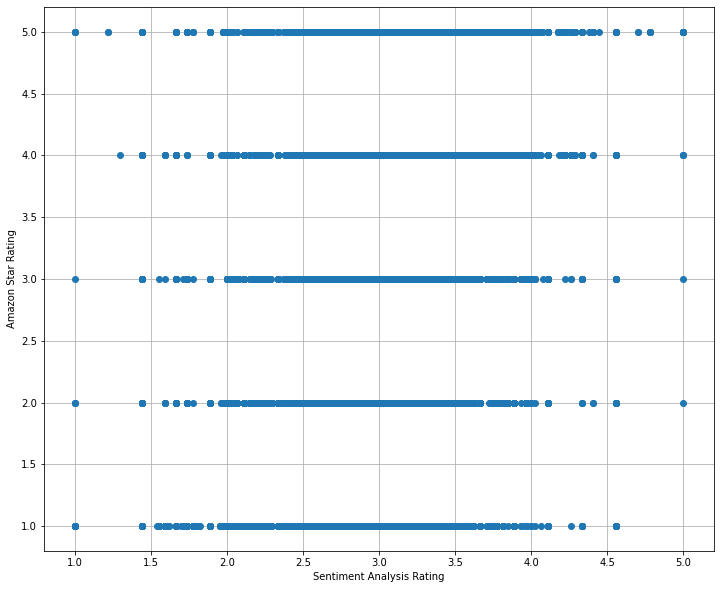

In [ ]:
from google.colab import files
from scipy import stats
#compute sentiment analysis rating as  matched_rate / number of matched words
df["avg_matched"] = df["matched_rate"] / df["matched"]

df = df.dropna()

#rescale afinn rating in range 1-5 (originally it was between -4 and +4)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler((1, 5))
df["avg_matched"] = scaler.fit_transform(df[["avg_matched"]])

#plot results
scatter = df.plot(x='avg_matched', y='star_rating', style='o', grid = True, legend=False, figsize=(12,10))

scatter.set_xlabel("Sentiment Analysis Rating")
scatter.set_ylabel("Amazon Star Rating")


#compute pearson correlation
print("Pearson correlation: {0}".format(stats.pearsonr(df["star_rating"], df["avg_matched"])[0]))


#uncomment to download a csv file of the result
#df.to_csv('NLP_result.csv', sep='\t' ,header=True, index = False)
#files.download("NLP_result.csv")



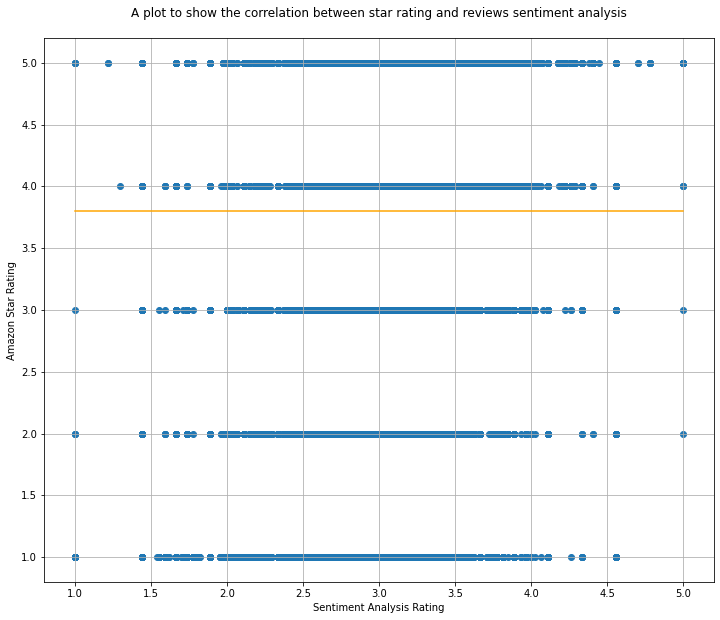


	Pearson correlation: 0.49522284015471746
	records acceptable: 65359 out of 95269


In [17]:
###TEST FOR CORRELATION LINE
import matplotlib.pyplot as plt
from google.colab import files
from scipy import stats
#compute sentiment analysis rating as  matched_rate / number of matched words
df["avg_matched"] = df["matched_rate"] / df["matched"]

df = df.dropna()

#rescale afinn rating in range 1-5 (originally it was between -4 and +4)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler((1, 5))
df["avg_matched"] = scaler.fit_transform(df[["avg_matched"]])

#plot results
#scatter = df.plot(x='avg_matched', y='star_rating', style='o', grid = True, legend=False, figsize=(12,10))
x=df['avg_matched']
y=df['star_rating']
m, b = np.polyfit(x, y, 1)
plt.figure(figsize=(12,10))
plt.scatter(x, y) 
plt.title('A plot to show the correlation between star rating and reviews sentiment analysis\n')
plt.xlabel('Sentiment Analysis Rating')
plt.ylabel('Amazon Star Rating')
plt.grid()

cor = stats.pearsonr(df["star_rating"], df["avg_matched"])[0]
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, cor))(np.unique(x)), color='orange')
plt.show()

#scatter.set_xlabel("Sentiment Analysis Rating")
#scatter.set_ylabel("Amazon Star Rating")


#compute pearson correlation
print("\n\tPearson correlation: {0}".format(stats.pearsonr(df["star_rating"], df["avg_matched"])[0]))

df['difference'] = df['star_rating'] - df['avg_matched']

ok = df[(df['difference'] <= 1.5) & (df['difference'] >= -1.5)]
good_records = ok.shape[0]
total_records = df.shape[0]

print('\trecords acceptable: {0} out of {1}'.format(good_records, total_records))

#uncomment to download a csv file of the result
#df.to_csv('NLP_result.csv', sep='\t' ,header=True, index = False)
#files.download("NLP_result.csv")